In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import scipy.stats as scs
from scipy import spatial
import sklearn
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from patsy import dmatrices
import seaborn as sns

/Users/janzaloudek/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
os.chdir('/Users/janzaloudek/Development/Skola/umass/diabetes/jupyter/trainingSet')
diagnosisT = pd.read_csv('training_SyncDiagnosis.csv')
allergyT = pd.read_csv('training_SyncAllergy.csv')
immunT = pd.read_csv('training_SyncImmunization.csv')
labObsT = pd.read_csv('training_SyncLabObservation.csv')
labPanT = pd.read_csv('training_SyncLabPanel.csv')
labResT = pd.read_csv('training_SyncLabResult.csv')
medicationT = pd.read_csv('training_SyncMedication.csv')
patientT = pd.read_csv('training_SyncPatient.csv')
patientCondT = pd.read_csv('training_SyncPatientCondition.csv')
smokingT = pd.read_csv('training_SyncPatientSmokingStatus.csv')
prescripT = pd.read_csv('training_SyncPrescription.csv')
trnscrpT = pd.read_csv('training_SyncTranscript.csv')
trnscrpAT = pd.read_csv('training_SyncTranscriptAllergy.csv')
trnscrpDT = pd.read_csv('training_SyncTranscriptDiagnosis.csv')
trnscrptMT = pd.read_csv('training_SyncTranscriptMedication.csv')
myfileT = pd.read_csv('myfile.csv', header=None)
conditionT = pd.read_csv('SyncCondition.csv')
smokingT = pd.read_csv('SyncSmokingStatus.csv')

#Section 1. Data Procession

BMI, Blood Pressure, Diseases

In [3]:
def makeBMI():
    trnscrpT['BMI'] = trnscrpT['BMI'].replace(0.000, np.nan)
    bmi1 = trnscrpT.groupby(['PatientGuid'])['BMI'].mean()
    bmi2 = trnscrpT.groupby(['PatientGuid'])['BMI'].max()
    bmi3 = trnscrpT.groupby(['PatientGuid'])['BMI'].min()
    bmi = pd.concat([bmi1, bmi2, bmi3], axis = 1)
    bmi.columns = ['MeanBMI', 'MaxBMI', 'MinBMI']
    bmi['isOverweight'] = 0
    bmi['isObese'] = 0
    bmi.loc[(bmi['MeanBMI'] >= 25) & (bmi['MeanBMI'] < 30), 'isOverweight'] = 1
    bmi.loc[bmi['MeanBMI'] >= 30, 'isObese'] = 1
    bmi['BMIDiff'] = np.abs(bmi['MaxBMI'] - bmi['MinBMI'])
    bmi = bmi.reset_index()
    return bmi

In [4]:
def makeBP():
    bloodpressure1 = trnscrpT.groupby(['PatientGuid'])[['SystolicBP', 'DiastolicBP']].mean()
    bloodpressure2 = trnscrpT.groupby(['PatientGuid'])[['SystolicBP', 'DiastolicBP']].max()
    bloodpressure3 = trnscrpT.groupby(['PatientGuid'])[['SystolicBP', 'DiastolicBP']].min()
    bloodpressure = pd.concat([bloodpressure1, bloodpressure2, bloodpressure3], axis = 1)
    bloodpressure.columns = ['meanSystolicBP', 'meanDiastolicBP', 'maxSystolicBP', 'maxDiastolicBP', 'minSystolicBP', 'minDiastolicBP']
    bloodpressure['SystDiff'] = np.abs(bloodpressure['maxSystolicBP'] - bloodpressure['minSystolicBP'])
    bloodpressure['DiastDiff'] = np.abs(bloodpressure['maxDiastolicBP'] - bloodpressure['minDiastolicBP'])
    bloodpressure['isPreHyp'] = 0
    bloodpressure['isStage1HBP'] = 0
    bloodpressure['isStage2HBP'] = 0
    bloodpressure.loc[((bloodpressure['meanSystolicBP'] >= 120) & (bloodpressure['meanSystolicBP'] < 140)) | ((bloodpressure['meanDiastolicBP'] >= 80) & (bloodpressure['meanDiastolicBP'] < 90)), 'isPreHyp'] = 1
    bloodpressure.loc[((bloodpressure['meanSystolicBP'] >= 140) & (bloodpressure['meanSystolicBP'] < 160)) | ((bloodpressure['meanDiastolicBP'] >= 90) & (bloodpressure['meanDiastolicBP'] < 100)), 'isStage1HBP'] = 1
    bloodpressure.loc[(bloodpressure['meanSystolicBP'] >= 160) | (bloodpressure['meanDiastolicBP'] >= 100), 'isStage2HBP'] = 1
    bloodpressure.loc[bloodpressure['isStage2HBP'] == 1, 'isStage1HBP'] = 0
    bloodpressure.loc[bloodpressure['isStage1HBP'] == 1, 'isPreHyp'] = 0
    bloodpressure = bloodpressure.reset_index()
    return bloodpressure

In [5]:
def makeConditions():
    diaganalysis = pd.merge(patientT, diagnosisT, on=['PatientGuid'])
    chidata = diaganalysis[['PatientGuid', 'DMIndicator', 'ICD9Code']].drop_duplicates()
    chidata.index = chidata['PatientGuid']
    dummies = pd.get_dummies(chidata['ICD9Code']).reset_index()
    dummies = dummies.groupby(['PatientGuid'])[dummies.columns[1:]].sum()
    dummies = dummies.replace(2, 1)
    chidata = chidata[['PatientGuid', 'DMIndicator']]
    chidata = chidata.drop_duplicates()
    chidata = pd.concat([chidata, dummies], axis=1)
    chidata['DMIndicator'] = chidata['DMIndicator'].astype(float)
    return chidata

In [6]:
def heartDisease(text):
    if bool(re.match('41[0-4]|42[0-5]|427|429|74[5-6]', text)) == True:
        return 1
    return 0
def CAD(text):
    if bool(re.match('41[0-4]|429', text)) == True:
        return 1
    return 0
def cardiomyopathy(text):
    if bool(re.match('42[0-5]', text)) == True:
        return 1
    return 0
def CHF(text):
    if bool(re.match('426', text)) == True:
        return 1
    return 0
def arrhythmias(text):
    if bool(re.match('427', text)) == True:
        return 1
    return 0
def heartdefects(text):
    if bool(re.match('74[5-6]', text)) == True:
        return 1
    return 0
def stroke(text):
    if bool(re.match('43[0-1]|43[3-6]|997.02', text)) == True:
        return 1
    return 0
def sleepApnea(text):
    if bool(re.match('727.23|780.57', text)) == True:
        return 1
    return 0
def gestDiab(text):
    if bool(re.match('648.8', text)) == True:
        return 1
    return 0
def polyOvary(text):
    if bool(re.match('256.4', text)) == True:
        return 1
    return 0
def frozenShoulder(text):
    if bool(re.match('726.0', text)) == True:
        return 1
    return 0
def hemochr(text):
    if bool(re.match('275.03', text)) == True:
        return 1
    return 0
def hepatitis(text):
    if bool(re.match('070.2|070.3', text)) == True:
        return 1
    return 0
def diabCompl(text):
    if bool(re.match('250.[1-3]|250.5|250.8|251.[0-2]|270.3|775.6|962.3', text)) == True:
        return 1
    return 0
def kidneyFailure(text):
    if bool(re.match('58[4-5]', text)) == True:
        return 1
    return 0
def dementia(text):
    if bool(re.match('331|290|294|797', text)) == True:
        return 1
    return 0
def acanthosis(text):
    if bool(re.match('701.2', text)) == True:
        return 1
    return 0
def blindness(text):
    if bool(re.match('369', text)) == True:
        return 1
    return 0
def sDysfunction(text):
    if bool(re.match('302.7', text)) == True:
        return 1
    return 0
def preDiabetes(text):
    if bool(re.match('790.29', text)) == True:
        return 1
    return 0

In [7]:
def ICD9Label(text):
    if bool(re.match('14[0-9]|2[0-3][0-9]', text)) == True:
        return 'neoplasms'
    elif bool(re.match('2[4-7][0-9]', text)) == True:
        return 'endoctrine'
    elif bool(re.match('28[0-9]', text)) == True:
        return 'blood'
    elif bool(re.match('29[0-9]|3[0-1][0-9]', text)) == True:
        return 'mental'
    elif bool(re.match('3[2-5][0-9]', text)) == True:
        return 'nervous'
    elif bool(re.match('3[6-8][0-9]', text)) == True:
        return 'sense'
    elif bool(re.match('39[0-9]|4[0-5][0-9]', text)) == True:
        return 'circulatory'
    elif bool(re.match('4[6-9][0-9]|5[0-1][0-9]', text)) == True:
        return 'respiratory'
    elif bool(re.match('5[2-7][0-9]', text)) == True:
        return 'digestive'
    elif bool(re.match('5[8-9][0-9]|6[0-2][0-9]', text)) == True:
        return 'genitourinary'
    elif bool(re.match('6[3-7][0-9]', text)) == True:
        return 'pregnancy'    
    elif bool(re.match('6[8-9][0-9]|70[0-9]', text)) == True:
        return 'skin'   
    elif bool(re.match('7[1-3][0-9]', text)) == True:
        return 'musculoskeletal'       
    elif bool(re.match('7[4-5][0-9]', text)) == True:
        return 'congenital' 
    elif bool(re.match('7[6-7][0-9]', text)) == True:
        return 'perinatal' 
    elif bool(re.match('7[8-9][0-9]', text)) == True:
        return 'symptoms or ill-defined' 
    elif bool(re.match('8[0-9][0-9]|9[0-9][0-9]', text)) == True:
        return 'injuries' 
    elif bool(re.match('E|V', text)) == True:
        return 'suppl' 
    else:
        return 'infectious'

In [8]:
def stripPeriods(text):
    result = re.sub('\.', "", text)
    return result

In [9]:
def makeSpecials():
    data = diagnosisT.copy()
    data['ICD9'] = data['ICD9Code'].apply(stripPeriods)
    data['hasHeartDisease'] = data['ICD9Code'].apply(heartDisease)
    data['hasCAD'] = data['ICD9Code'].apply(CAD)
    data['hasCardiomyo'] = data['ICD9Code'].apply(cardiomyopathy)
    data['hasArrhy'] = data['ICD9Code'].apply(arrhythmias)
    data['hasHeartDefects'] = data['ICD9Code'].apply(heartdefects)
    data['hasCHF'] = data['ICD9Code'].apply(CHF)
    data['hasStroke'] = data['ICD9Code'].apply(stroke)
    data['hasSleepA'] = data['ICD9Code'].apply(sleepApnea)
    data['hasGestDiab'] = data['ICD9Code'].apply(gestDiab)
    data['hasPolyO'] = data['ICD9Code'].apply(polyOvary)
    data['hasFrozenShoulder'] = data['ICD9Code'].apply(frozenShoulder)
    data['hasHemoChr'] = data['ICD9Code'].apply(hemochr)
    data['hasHepatitis'] = data['ICD9Code'].apply(hepatitis)
    data['hasDiabComp'] = data['ICD9Code'].apply(diabCompl)
    data['hasKidneyF'] = data['ICD9Code'].apply(kidneyFailure)
    data['hasDementia'] = data['ICD9Code'].apply(dementia)
    data['hasAcanthosis'] = data['ICD9Code'].apply(acanthosis)
    data['hasBlindness'] = data['ICD9Code'].apply(blindness)
    data['hasSDysf'] = data['ICD9Code'].apply(sDysfunction)
    data['hasPreDiab'] = data['ICD9Code'].apply(preDiabetes)
    diagnosisSummary = data.groupby(['PatientGuid'])[['hasHeartDisease', 'hasCHF', 'hasStroke', 'hasSleepA', 'hasGestDiab','hasPolyO', 'hasFrozenShoulder', 'hasHemoChr','hasHepatitis', 'hasDiabComp', 'hasKidneyF', 'hasDementia','hasAcanthosis', 'hasBlindness' ,'hasSDysf', 'hasPreDiab']].max()
    diagnosisSummary = diagnosisSummary.reset_index()
    return diagnosisSummary

In [10]:
def getPatientAge():
    data=patientT.copy()
    data.drop('PracticeGuid', axis=1, inplace=True)
    data.drop('State', axis=1, inplace=True)
    data['Age'] = 2015 - data['YearOfBirth']
    data.drop('YearOfBirth', axis=1, inplace=True)
    return data

In [11]:
def makeICD9Labels():
    data = diagnosisT.copy()
    data['ICD9Label'] = data['ICD9Code'].apply(ICD9Label)
    data['Counts'] = 1
    ICD9Labeldata = data.groupby(['PatientGuid', 'ICD9Label'])['Counts'].max().reset_index().pivot('PatientGuid', 'ICD9Label', 'Counts').reset_index()
    ICD9Labeldata = ICD9Labeldata.fillna(0)
    return ICD9Labeldata

In [12]:
bloodpressure = makeBP()
bmi = makeBMI()
conditions = makeConditions()
specials = makeSpecials()
patients = getPatientAge()
icd9lab = makeICD9Labels()

In [13]:
def makeSimilarity():
    columns = conditions.columns[2:]
    chitest = {}
    cmatrix = {}
    cos = {}
    percent = {}
    for column in columns:
        cm = confusion_matrix(np.array(conditions['DMIndicator']), np.array(conditions[column]))
        cmatrix[column] = cm
        chitest[column]= scs.chi2_contingency(cm)[1]
        cos[column] = 1 - spatial.distance.cosine(conditions['DMIndicator'], conditions[column])
        percent[column] = float(cm[1][1])/(float(cm[0][1]) + float(cm[1][1]))
    return cos, chitest, cmatrix, percent

In [14]:
cos = makeSimilarity()[0]

In [15]:
def getICD9(threshold=0.02):
    ICD9 = []
    for key in cos.keys():
        if cos[key] > threshold:
            ICD9.append(key)
    return ICD9

In [16]:
print(bloodpressure.shape, bmi.shape, specials.shape, patients.shape, conditions.shape, icd9lab.shape)

(9948, 12) (9948, 7) (9948, 17) (9948, 4) (9948, 3945) (9948, 20)


In [17]:
import sys
sys.setrecursionlimit(10000)

In [18]:
def optimizer():
    AUC = []
    threshold = []
        
    for i in list(np.arange(0.01, max(cos.values()), 0.01)):
        #piece together the datasets
        ICD9 = getICD9(i)
        newconditions = pd.concat([conditions['PatientGuid'], conditions[ICD9]], axis=1)
        patientdata = pd.merge(patients, newconditions, how='inner', on =['PatientGuid'])
        patientdata = pd.merge(patientdata, specials, how='inner', on =['PatientGuid'])
        patientdata = pd.merge(patientdata, icd9lab, how='inner', on =['PatientGuid'])
        patientdata = pd.merge(patientdata, bloodpressure, how='inner', on =['PatientGuid'])
        patientdata = pd.merge(patientdata, bmi, how='inner', on =['PatientGuid'])

        #create model variables
        modelelements = '") + Q("'.join(patientdata.columns[2:])
        modelelements = 'Q("' + modelelements + '")'
        formula = 'DMIndicator ~ ' + modelelements
        y, X = dmatrices(formula, data=patientdata, return_type='dataframe')
        X = X.drop('Intercept', 1)

        #setting up test train split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        y_train = np.array(y_train).ravel()
        y_test = np.array(y_test).ravel()
    
        #run logistic regression
        n_samples = X_train.shape[0]
        model1 = LogisticRegression()
        model1.fit(X_train, y_train)
        y_pred_proba = model1.predict_proba(X_test)
        #cv = sklearn.cross_validation.ShuffleSplit(n_samples, n_iter=20, test_size=0.2, random_state=1)
        #logloss = sklearn.cross_validation.cross_val_score(model1, X_train, y_train, cv=cv, scoring='log_loss')
        #mlogloss = -logloss.mean()
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba[:,1])
        auc = sklearn.metrics.auc(fpr, tpr)
        #logloss = sklearn.metrics.log_loss(y_test, y_pred_proba[:,1])
        
        threshold.append(i)
        AUC.append(auc)
        
    return threshold, AUC

In [19]:
threshold, AUC = optimizer()

In [20]:
bestthreshold = threshold[AUC.index(max(AUC))]
bestthreshold

0.080000000000000002

In [ ]:
%matplotlib inline
matplotlib.style.use('ggplot')
plt.plot(threshold, AUC)
plt.show()

In [22]:
def makeData(threshold = 0.0001):
    ICD9 = getICD9(threshold)
    newconditions = pd.concat([conditions['PatientGuid'], conditions[ICD9]], axis=1)
    patientdata = pd.merge(patients, newconditions, how='inner', on =['PatientGuid'])
    patientdata = pd.merge(patientdata, specials, how='inner', on =['PatientGuid'])
    patientdata = pd.merge(patientdata, icd9lab, how='inner', on =['PatientGuid'])
    patientdata = pd.merge(patientdata, bloodpressure, how='inner', on =['PatientGuid'])
    patientdata = pd.merge(patientdata, bmi, how='inner', on =['PatientGuid'])

    #create model variables
    modelelements = '") + Q("'.join(patientdata.columns[2:])
    modelelements = 'Q("' + modelelements + '")'
    formula = 'DMIndicator ~ ' + modelelements
    y, X = dmatrices(formula, data=patientdata, return_type='dataframe')
    X = X.drop('Intercept', 1)
#     print(str(patientdata.columns))
#     print(str(patientdata.columns[2:]))
#     print(str(y))
#     print(str(X))
    print(X.shape)
    print(y.shape)

    #setting up test train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
    
    return X_train, y_train, X_test, y_test

In [23]:
X_train, y_train, X_test, y_test = makeData()

(9947, 2324)
(9947, 1)


Accuracy: Training (CV)

In [24]:
n_samples = X_train.shape[0]
model1 = LogisticRegression()
cv = sklearn.cross_validation.ShuffleSplit(n_samples, n_iter=10, test_size=0.3, random_state=1)
scores = sklearn.cross_validation.cross_val_score(model1, X_train, y_train, cv=cv)
print(scores.mean())

0.816415410385


Accuracy: Test

In [25]:
model1.fit(X_train, y_train)
model1.score(X_test, y_test)

0.82462311557788948

In [ ]:
y_pred = model1.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labelname = model1.classes_
sns.heatmap(cm, annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

Classification Report

In [27]:
report = classification_report(y_test.ravel(), y_pred)
print(report)

             precision    recall  f1-score   support

        0.0       0.85      0.95      0.90      1603
        1.0       0.60      0.30      0.40       387

avg / total       0.80      0.82      0.80      1990



ROC

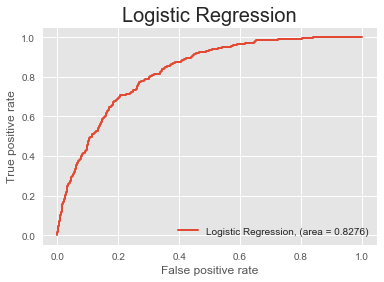

In [28]:
y_pred_proba = model1.predict_proba(X_test)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba[:,1])
roc_rates = [fpr, tpr]
auc = sklearn.metrics.auc(fpr, tpr)
plt.title("Logistic Regression", fontsize = 20)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
labelname = "Logistic Regression" + ", (area = %0.4f)" % auc
plt.plot(roc_rates[0], roc_rates[1], linewidth = 2, label = labelname)
plt.legend(loc = 4)

Log Loss: Testing

In [29]:
sklearn.metrics.log_loss(y_test, y_pred_proba[:,1])

0.37902851212998018

In [46]:
from sklearn.preprocessing import normalize
from keras.utils import to_categorical
X_train.shape
X_train_norm = normalize(X_train)
y_train_norm = to_categorical(y_train, num_classes=2)

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential([
    Dense(1000, input_dim=2324),
    Activation('relu'),
    Dense(500),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy', 'binary_accuracy'])

nn_history = model.fit(X_train_norm, y_train_norm, epochs=80, batch_size=64, verbose=2)

Epoch 1/80
5s - loss: 0.4690 - acc: 0.8092 - binary_accuracy: 0.8092
Epoch 2/80
7s - loss: 0.4394 - acc: 0.8094 - binary_accuracy: 0.8094
Epoch 3/80
8s - loss: 0.4207 - acc: 0.8091 - binary_accuracy: 0.8091
Epoch 4/80
9s - loss: 0.4146 - acc: 0.8144 - binary_accuracy: 0.8144
Epoch 5/80
9s - loss: 0.4091 - acc: 0.8139 - binary_accuracy: 0.8139
Epoch 6/80
11s - loss: 0.4000 - acc: 0.8194 - binary_accuracy: 0.8194
Epoch 7/80
13s - loss: 0.3933 - acc: 0.8225 - binary_accuracy: 0.8225
Epoch 8/80
15s - loss: 0.3916 - acc: 0.8261 - binary_accuracy: 0.8261
Epoch 9/80
16s - loss: 0.3880 - acc: 0.8295 - binary_accuracy: 0.8295
Epoch 10/80
17s - loss: 0.3830 - acc: 0.8278 - binary_accuracy: 0.8278
Epoch 11/80
19s - loss: 0.3788 - acc: 0.8251 - binary_accuracy: 0.8251
Epoch 12/80
17s - loss: 0.3738 - acc: 0.8268 - binary_accuracy: 0.8268
Epoch 13/80
18s - loss: 0.3753 - acc: 0.8306 - binary_accuracy: 0.8306
Epoch 14/80
18s - loss: 0.3723 - acc: 0.8301 - binary_accuracy: 0.8301
Epoch 15/80
19s - lo

In [64]:
X_test_norm = normalize(X_test)
y_test_norm = to_categorical(y_test, num_classes=2)
score = model.evaluate(X_test_norm, y_test_norm)
score

1760/1990 [=========================>....] - ETA: 0s

[0.55086225804372047, 0.81658291457286436, 0.81658291457286436]

In [1]:
print(nn_history.epoch)
# summarize history for accuracy
plt.plot(nn_history.history['acc'])
plt.plot(nn_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(nn_history.history['loss'])
plt.plot(nn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'nn_history' is not defined

In [74]:
model22 = Sequential([
    Dense(1000, input_dim=2324),
    Activation('relu'),
    Dense(500),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
])

model22.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'binary_accuracy'])

nn_history22 = model.fit(X_train_norm, y_train_norm, epochs=80, batch_size=62, verbose=2, validation_data=(X_test_norm, y_test_norm))

Train on 7957 samples, validate on 1990 samples
Epoch 1/80
25s - loss: 0.2641 - acc: 0.8878 - binary_accuracy: 0.8878 - val_loss: 0.7056 - val_acc: 0.8181 - val_binary_accuracy: 0.8181
Epoch 2/80
25s - loss: 0.2565 - acc: 0.8897 - binary_accuracy: 0.8897 - val_loss: 0.6069 - val_acc: 0.8206 - val_binary_accuracy: 0.8206
Epoch 3/80
25s - loss: 0.2625 - acc: 0.8864 - binary_accuracy: 0.8864 - val_loss: 0.5334 - val_acc: 0.8236 - val_binary_accuracy: 0.8236
Epoch 4/80
25s - loss: 0.2564 - acc: 0.8899 - binary_accuracy: 0.8899 - val_loss: 1.2399 - val_acc: 0.6151 - val_binary_accuracy: 0.6151
Epoch 5/80
25s - loss: 0.2568 - acc: 0.8860 - binary_accuracy: 0.8860 - val_loss: 0.5592 - val_acc: 0.8141 - val_binary_accuracy: 0.8141
Epoch 6/80
25s - loss: 0.2562 - acc: 0.8905 - binary_accuracy: 0.8905 - val_loss: 0.6197 - val_acc: 0.8181 - val_binary_accuracy: 0.8181
Epoch 7/80
25s - loss: 0.2555 - acc: 0.8874 - binary_accuracy: 0.8874 - val_loss: 0.6959 - val_acc: 0.7789 - val_binary_accuracy: 

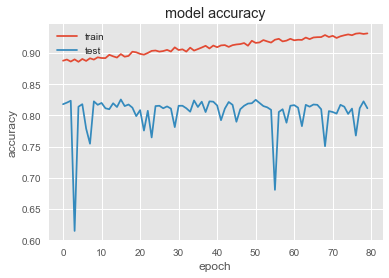

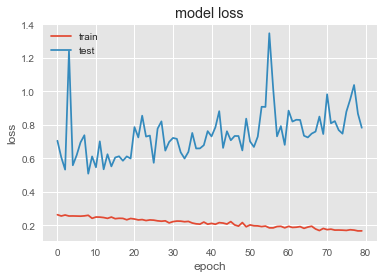

In [75]:
# summarize history for accuracy
plt.plot(nn_history22.history['acc'])
plt.plot(nn_history22.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(nn_history22.history['loss'])
plt.plot(nn_history22.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [80]:
nn_predict = model.predict_classes(X_test_norm)
nn_sc = sklearn.metrics.log_loss(y_test, nn_predict)
nn_sc

1920/1990 [===========================>..] - ETA: 0s

6.5086152242010051

##### Logistic Regression with RFECV

In [40]:
rfecv = sklearn.feature_selection.RFECV(estimator=model1, step=1, cv=cv, scoring='recall') 
rfecv.fit(X_train, y_train.ravel())
rfecv.score(X_test, y_test.ravel())

KeyboardInterrupt: 

In [ ]:
y_pred = rfecv.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labelname = model1.classes_
sns.heatmap(cm, annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

In [ ]:
report = classification_report(y_test.ravel(), y_pred)
print(report)

In [ ]:
y_pred_proba = rfecv.predict_proba(X_test)
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba[:,1])
roc_rates = [fpr, tpr]
auc = sklearn.metrics.auc(fpr, tpr)
plt.title("Logistic Regression", fontsize = 20)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
labelname = "Logistic Regression" + ", (area = %0.3f)" % auc
plt.plot(roc_rates[0], roc_rates[1], linewidth = 2, label = labelname)
plt.legend(loc = 4)

In [ ]:
n_samples = X_train[:, rfecv.support_].shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=20, test_size=0.2, random_state=1)
model = LogisticRegression()
logloss = cross_validation.cross_val_score(model, X_train[:, rfecv.support_], y_train.ravel(), cv=cv, scoring='log_loss')
print(-logloss.mean())

In [ ]:
sklearn.metrics.log_loss(y_test.ravel(), y_pred_proba[:,1])